# Predicting credit default with XGBoost
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem **_

_NOTE: This notebook was created and tested using the `Python 3 (Data Science)` kernel._

---

---

## Contents

1. [Background](#Background)
1. [Preparation](#Preparation)
1. [Data](#Data)
    1. [Exploration](#Exploration)
    1. [Transformation](#Transformation)
1. [Training](#Training)
1. [Hosting](#Hosting)
1. [Evaluation](#Evaluation)
1. [Extensions](#Extensions)

---

## Background

The ability to forecast and discriminate is central in many medical situations. Standard statistical techniques such as discriminate
analysis, regression analysis, and factor analysis have been used to provide this ability. However, even with the existence of hidden
functional relationships that can provide forecasting ability, standard statistical techniques may be unsuccessful. The standard
statistical methods may provide disappointing results when:
1. The sample size is small.
2. The form of the underlying functional relationship is not known.
3. The underlying functional relationships involve complex interactions and intercorrelations among a number of variables.

These conditions are not unusual in medical problems. In such situations, neural network approaches offer promise.

In this notebook, we will be using the XGBoost algorithm to forecast the onset of non-insulin-dependent diabetes mellitus (DM) within a five-year period. The dataset used is a Public Domain dataset provided by the National Institute of Diabetes and Digestive and Kidney Diseases and first explored in [[1]](#ack-1).

The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. 

We will be going through the following steps:

* Preparing your Amazon SageMaker notebook
* Downloading data from the internet into Amazon SageMaker
* Investigating and transforming the data so that it can be fed to Amazon SageMaker algorithms
* Estimating a model using the Gradient Boosting algorithm
* Evaluating the effectiveness of the model
* Setting the model up to make on-going predictions

---

## Install additional libraries

[Pandas profiling](https://github.com/pandas-profiling/pandas-profiling) works great for smaller datasets. Pandas profiling does not come preinstalled on the Data Science Kernel, but we can install it with pip.

In [1]:
!pip install pandas-profiling[notebook]

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 243 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 32.7 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 340 kB/s  eta 0:00:01
     |████████████████████████████████| 3.1 MB 64.4 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 296 kB/s  eta 0:00:01
     |████████████████████████████████| 1.1 MB 59.9 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 29.8 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 48.9 MB/s eta 0:00:01
     |████████████████████████████████| 82

## Preparation

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [10]:
import boto3
import re
import sagemaker # Amazon SageMaker's Python SDK provides many helper functions

session = sagemaker.Session()

bucket = session.default_bucket()
prefix = 'sagemaker/credit-xgboost'
 
# Define IAM role
role = sagemaker.get_execution_role()

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20201031T094356 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


In [11]:
(bucket,prefix,role)

('sagemaker-eu-north-1-641758013508',
 'sagemaker/credit-xgboost',
 'arn:aws:iam::641758013508:role/service-role/AmazonSageMaker-ExecutionRole-20201031T094356')

Now let's bring in the Python libraries that we'll use throughout the analysis

In [12]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker.deserializers                    # Converts strings for HTTP POST requests on inference

---

## Data

The dataset should already be available in the repository under the dataset folder. Now lets read this into a Pandas data frame and take a look.


In [15]:
data = pd.read_csv('./dataset/UCI_CC.csv', ';')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


Let's talk about the data.  At a high level, we can see:

* We have 30000 user and their credits records
* 25 features per record
* The features are numeric
* The data is not sorted

_**Specifics on each of the features:**_

*Features:*
* `ID`: ID of user
* `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* `SEX`: Gender (1=male, 2=female)
* `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* `Marriage`: Marital status (1=married, 2=single, 3=other)
* `AGE`: Age in years
* `PAY_1`: Repayment status for this month. (-1=paid duly, 1=payment delayed 1 month, 2=payment delayed 2 months, [...], 9=payment delayed 9 months or more)
* `PAY_2`: Repayment status for last month. (same as above)
* `PAY_3`: Repayment status for 2 months ago. (same as above)
* `PAY_4`: Repayment status for 3 months ago. (same as above)
* `PAY_5`: Repayment status for 4 months ago. (same as above)
* `PAY_6`: Repayment status for 5 months ago. (same as above)
* `BILL_AMT1`: Amount of bill this month.
* `BILL_AMT2`: Amount of bill last month.
* `BILL_AMT3`: Amount of bill 2 months ago.
* `BILL_AMT4`: Amount of bill 3 months ago.
* `BILL_AMT5`: Amount of bill 4 months ago.
* `BILL_AMT6`: Amount of bill 5 months ago.
* `PAY_AMT1`: Amount of payment made this month.
* `PAY_AMT2`: Amount of payment made last month.
* `PAY_AMT3`: Amount of payment made 2 months ago.
* `PAY_AMT4`: Amount of payment made 3 months ago.
* `PAY_AMT5`: Amount of payment made 4 months ago.
* `PAY_AMT6`: Amount of payment made 5 months ago.

*Target variable:*
* `default.payment.next.month`: Default payment (1=yes, 0=no).



### Exploration
Let's start exploring the data.  First, let's understand how the features are distributed.

col_0,% observations
LIMIT_BAL,
10000,0.016433
110000,0.019600
120000,0.024200
130000,0.024300
140000,0.024967
...,...
780000,0.000067
7×10^+05,0.000267
80000,0.052233


col_0,% observations
BILL_AMT1,
-1,0.000533
-10,0.000367
-100,0.000067
-1000,0.000100
-101,0.000033
...,...
99932,0.000033
99938,0.000033
99958,0.000033


col_0,% observations
BILL_AMT2,
-1,0.000600
-10,0.000433
-100,0.000067
-1000,0.000133
-101,0.000067
...,...
99964,0.000033
9998,0.000033
9999,0.000033


col_0,% observations
BILL_AMT3,
-1,0.000800
-10,0.000467
-100,0.000033
-1000,0.000067
-1001,0.000067
...,...
9996,0.000033
99961,0.000033
99973,0.000033


col_0,% observations
BILL_AMT4,
-1,0.000833
-10,0.000533
-100,0.000033
-1000,0.000200
-1001,0.000033
...,...
9997,0.000033
99970,0.000033
99973,0.000033


col_0,% observations
BILL_AMT5,
-1,0.000800
-10,0.000433
-100,0.000067
-1000,0.000133
-1001,0.000033
...,...
9997,0.000033
9998,0.000033
99983,0.000033


col_0,% observations
BILL_AMT6,
-1,0.000833
-10,0.000500
-100,0.000033
-1000,0.000233
-1005,0.000033
...,...
99947,0.000033
9995,0.000033
99961,0.000033


col_0,% observations
PAY_AMT1,
0,0.174967
1,0.000300
10,0.000333
100,0.000233
1000,0.012167
...,...
9978,0.000033
99787,0.000033
9983,0.000033


col_0,% observations
PAY_AMT2,
0,0.179867
1,0.000500
10,0.000333
100,0.000433
1000,0.019800
...,...
9973,0.000033
9976,0.000033
998,0.000067


col_0,% observations
PAY_AMT3,
0,0.198933
1,0.000433
10,0.000300
100,0.000333
1000,0.036767
...,...
9976,0.000033
998,0.000033
9984,0.000033


col_0,% observations
PAY_AMT4,
0,0.213600
1,0.000733
10,0.000367
100,0.000933
1000,0.046467
...,...
99669,0.000033
997,0.000100
998,0.000133


col_0,% observations
PAY_AMT5,
0,0.223433
1,0.000700
10,0.000200
100,0.000733
1000,0.044667
...,...
998,0.000233
9980,0.000067
99822,0.000033


col_0,% observations
PAY_AMT6,
0,0.239100
1,0.000667
10,0.000067
100,0.000933
1000,0.043300
...,...
998,0.000167
9986,0.000033
999,0.000233


,ID,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,0.221200
std,8660.398374,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,0.415062
min,1.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000
25%,7500.750000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,15000.500000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22500.250000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,1.000000


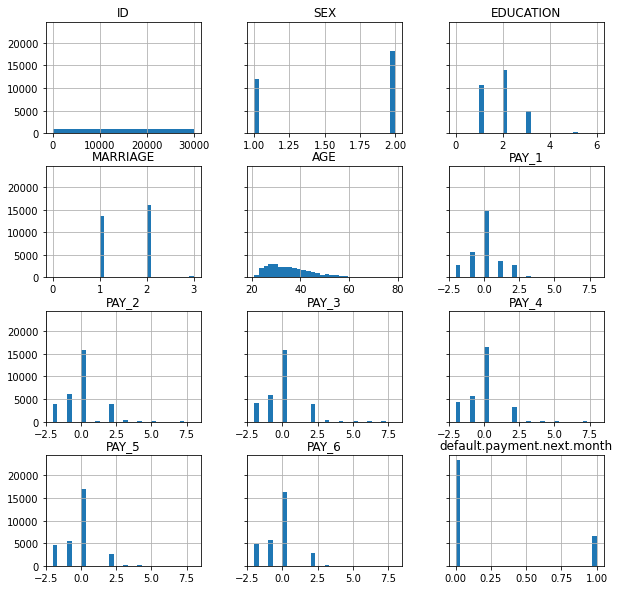

In [16]:
# Frequency tables for each categorical feature
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(data.describe())
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

Notice that:
* The `Age` feature does not follow a normal distribution as it is skewed to the left. This is further confirmed by the fact that the average age is 33 whereas the median age is 29 (in the case of a normal distribution, these values would be approximately equal). Additionally, none of the values in the range are abnormal, with the minimum age of 21 and the maximum age of 81 both being common-sense age values.
* The `BMI`, `BloodPressure` and `SkinThickness` features visually seem to be following a normal distribution, if we ignore the outlier 0 values (are these missing values?). This will be verified and corrected at a later point.
* The `DiabetesPedigreeFunction` feature is skewed to the left and has no zero values.
* The `Glucose` feature does not follow a normal distribution but also exhibits 0 values. 
* The `Insulin` feature has a high occurrence of zero-values, which is an abnormal value for the feature. These values will have to be imputed. It also has a rather long tail.  Do we need to handle these few observations with large values differently?
* The `Pregnanices` feature occurs in distinct buckets, should this be treated as a categorical column?
* The `Outcome` variable is imbalanced, with the `0` class having the highest frequency 

Next, let's look at how our features relate to the `Outcome` that we are attempting to predict. 

We could display the histograms side by side. Below is an example for `BloodPressure`:

In [ ]:
hist = data[['BloodPressure', 'Outcome']].hist(by='Outcome', bins=30)

Instead, we will make use of violin plots to visualize the probability density and the distribution at the same time. 

In [ ]:
import seaborn as sns

ax = sns.violinplot(x="Outcome", y='BloodPressure', data=data, split=True)

On close observation, we can see that the box plot for 1 (Diabetic) inside the violin is a little more away from the horizontal axis than the box plot for 0 (Non Diabetic). It can be implied that diabetics seem to have a higher blood pressure than the non-diabetics. The bottom tail of the violins indicates the zero values we need to replace.

Let us render the violin plots for the other variables as well.

In [ ]:
for column in data.select_dtypes(exclude=['object']).columns:
    if column not in ['Outcome','BloodPressure']:
        print(column)
        ax = sns.violinplot(x="Outcome", y=column, data=data, split=True)
        plt.show()

Notice that:

* For the `BMI` and `DiabetesPedigreeFunction` features, values are generally higher for diabetics than non-diabetics.
* For the `Glucose` feature, there is a significant veritcal distance between the diabetic and non-diabetic box plots.

Now let's look at how our features relate to one another.

In [ ]:
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

Notice that:
* Features vary widely in their relationship with one another.  Some with highly negative correlation, others with highly positive correlation.
* Relationships between features is non-linear and discrete in many cases.
* A significant correlation can be observed between `Pregnancies` and `Age`. 

To further confirm, we calculate the correlation coefficient.

In [ ]:
from scipy.stats import pearsonr

corr, _ = pearsonr(data['Age'], data['Pregnancies'])
print('Pearsons correlation: %.3f' % corr)

Most of the custom plots we rendered above can be generated efficiently by using [Pandas profiling](https://github.com/pandas-profiling/pandas-profiling), which works great for smaller datasets.

The output is generated as a HTML report which can be embedded directly in the Jupyter notebook.

In [ ]:
from pandas_profiling import ProfileReport

profile_data = data
profile = ProfileReport(profile_data, title="Diabetes Dataset Report")
profile

### Transformation

Cleaning up data is part of nearly every machine learning project.  It arguably presents the biggest risk if done incorrectly and is one of the more subjective aspects in the process.  Several common techniques include:

* Handling missing values: Some machine learning algorithms are capable of handling missing values, but most would rather not.  Options include:
 * Removing observations with missing values: This works well if only a very small fraction of observations have incomplete information.
 * Removing features with missing values: This works well if there are a small number of features which have a large number of missing values.
 * Imputing missing values: Entire [books](https://www.amazon.com/Flexible-Imputation-Missing-Interdisciplinary-Statistics/dp/1439868247) have been written on this topic, but common choices are replacing the missing value with the mode or mean of that column's non-missing values.
* Converting categorical to numeric: The most common method is one hot encoding, which for each feature maps every distinct value of that column to its own feature which takes a value of 1 when the categorical feature is equal to that value, and 0 otherwise.
* Oddly distributed data and outliers: Although for non-linear models like Gradient Boosted Trees, this has very limited implications, parametric models like regression can produce wildly inaccurate estimates when fed highly skewed data.  In some cases, simply taking the natural log of the features is sufficient to produce more normally distributed data.  In others, bucketing values into discrete ranges is helpful.  These buckets can then be treated as categorical variables and included in the model when one hot encoded.
* Handling more complicated data types: Mainpulating images, text, or data at varying grains is not in the scope of this notebook.

The XGBoost algorithm tends to do well when handling outliers, so we will do not use any methodologies to address this. 

However, we have already identified several features with zero values. Because the dataset is small, we will not drop the observations with zero values, but we will replace them with the median value, computed separately for the two outcome classes.

In [ ]:
df1 = data.loc[data['Outcome'] == 1]
df2 = data.loc[data['Outcome'] == 0]

columnsToImpute = ['BloodPressure', 'BMI', 'Glucose', 'Insulin', 'SkinThickness']

for column in columnsToImpute:
    df1 = df1.replace({column:0}, np.median(df1[column]))
    df2 = df2.replace({column:0}, np.median(df2[column]))

dataframe = [df1, df2]
data = pd.concat(dataframe)

In [ ]:
display(data.describe())

We have also identified a categorical column (`pregnancies`), for which we will apply one-hot encoding.

In [ ]:
data = data.astype({'Pregnancies':'category','Outcome':'category'}) 
model_data = pd.get_dummies(data) # Convert categorical variables to sets of indicators

In [ ]:
model_data

When building a model whose primary goal is to predict a target value on new data, it is important to understand overfitting.  Supervised learning models are designed to minimize error between their predictions of the target value and actuals, in the data they are given.  This last part is key, as frequently in their quest for greater accuracy, machine learning models bias themselves toward picking up on minor idiosyncrasies within the data they are shown.  These idiosyncrasies then don't repeat themselves in subsequent data, meaning those predictions can actually be made less accurate, at the expense of more accurate predictions in the training phase.

The most common way of preventing this is to build models with the concept that a model shouldn't only be judged on its fit to the data it was trained on, but also on "new" data.  There are several different ways of operationalizing this, holdout validation, cross-validation, leave-one-out validation, etc.  For our purposes, we'll simply randomly split the data into 3 uneven groups.  The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

In [ ]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [ ]:
pd.concat([train_data['Outcome_1'], train_data.drop(['Outcome_0', 'Outcome_1'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['Outcome_1'], validation_data.drop(['Outcome_0', 'Outcome_1'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
pd.concat([test_data['Outcome_1'], test_data.drop(['Outcome_0', 'Outcome_1'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
test_data.drop(['Outcome_0', 'Outcome_1'], axis=1).to_csv('test-no-outcomes.csv', index=False, header=False)

merged_data = train_data.append(validation_data)
pd.concat([merged_data['Outcome_1'], merged_data.drop(['Outcome_0', 'Outcome_1'], axis=1)], axis=1).to_csv('merged.csv', index=False, header=False)

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test-no-outcomes/test-no-outcomes.csv')).upload_file('test-no-outcomes.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'merged/merged.csv')).upload_file('merged.csv')

---

## Training
Now we know that most of our features have skewed distributions, some are highly correlated with one another, and some appear to have non-linear relationships with our target variable.  Also, for targeting future prospects, good predictive accuracy is preferred to being able to explain why that prospect was targeted.  Taken together, these aspects make gradient boosted trees a good candidate algorithm.

There are several intricacies to understanding the algorithm, but at a high level, gradient boosted trees works by combining predictions from many simple models, each of which tries to address the weaknesses of the previous models.  By doing this the collection of simple models can actually outperform large, complex models.  Other Amazon SageMaker notebooks elaborate on gradient boosting trees further and how they differ from similar algorithms.

`xgboost` is an extremely popular, open-source package for gradient boosted trees.  It is computationally powerful, fully featured, and has been successfully used in many machine learning competitions.  Let's start with a simple `xgboost` model, trained using Amazon SageMaker's managed, distributed training framework.

First we'll need to specify the ECR container location for Amazon SageMaker's implementation of XGBoost.

In [ ]:
container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, version='latest')

Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [ ]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

First we'll need to specify training parameters to the estimator.  This includes:
1. The `xgboost` algorithm container
1. The IAM role to use
1. Training instance type and count
1. S3 location for output data
1. Algorithm hyperparameters

And then a `.fit()` function which specifies:
1. S3 location for input data.  In this case we have both a training and validation set which are passed in.

In [ ]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

---

## Hosting
Now that we've trained the `xgboost` algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

---

## Evaluation
There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values.  In this case, we're simply predicting whether the patient has diabetes (`1`) or not (`0`), which produces a simple confusion matrix.

First we'll need to determine how we pass data into and receive data from our endpoint.  Our data is currently stored as NumPy arrays in memory of our notebook instance.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

*Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.*

In [ ]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [ ]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['Outcome_0', 'Outcome_1'], axis=1).to_numpy())

Now we'll check our confusion matrix to see how well we predicted versus actuals.

In [ ]:
pd.crosstab(index=test_data['Outcome_1'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

So out of the 77 patients, we predicted 25 would have diabetes and 21 of them actually did. We also had 2 patients who we predicted would not get diabetes but actually did. The model can (and should) be tuned to improve this.  

_Note that because there is some element of randomness in the algorithm's subsample, your results may differ slightly from the text written above._

Let us now compute the ROC curve in order to compare with the original paper.

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_data['Outcome_1'], predictions)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

---

## Extensions

This example analyzed a relatively small dataset, but utilized Amazon SageMaker features such as distributed, managed training and real-time model hosting, which could easily be applied to much larger problems.  In order to improve predictive accuracy further, we could tweak value we threshold our predictions at to alter the mix of false-positives and false-negatives, or we could explore techniques like hyperparameter tuning.  In a real-world scenario, we would also spend more time engineering features by hand and would likely look for additional datasets to include which contain customer information not available in our initial dataset.

### (Optional) Clean-up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
xgb_predictor.delete_endpoint()

### Acknowledgements
#### [1] <a id="ack-1"></a>
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). [Using the ADAP learning algorithm to forecast the onset of diabetes mellitus](https://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC2245318&blobtype=pdf). In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.
